In [10]:
# Adrian Marinovich
# Springboard - Data Science Career Track 
# Capstone Project #2
# Modeling 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import deque
import csv
import cv2
import glob
import numpy as np
import operator
import os
import os.path
import pickle
import random
import shutil
import sys
import threading
import time
from tqdm import tqdm

from scipy.stats import reciprocal, uniform
from scipy.misc import imsave

import tensorflow as tf

# for reproducibility:
np.random.seed(41)
tf.reset_default_graph()
tf.set_random_seed(51)
random.seed(61)
os.environ['PYTHONHASHSEED'] = '0'
    
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import VGG16
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import ZeroPadding3D
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.layers.wrappers import TimeDistributed
from keras.models import Model, load_model
from keras.models import model_from_yaml
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical

from sklearn.svm import LinearSVC 
from sklearn.svm import SVC 

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier

# setup plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Using TensorFlow backend.


In [ ]:
# Example images

AxesImage(54,36;334.8x217.44)


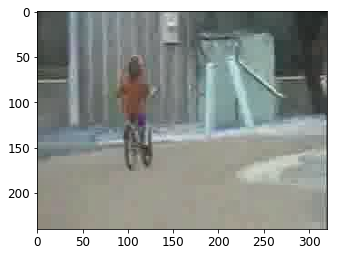

In [43]:
imagePath1 = '/home/adrian01/ucf101/train/Biking/v_Biking_g25_c04-0201.jpg'
image1 = cv2.imread(imagePath1)
print(plt.imshow(image1))

In [44]:
img1 = cv2.imread(imagePath1)
img1.shape

(240, 320, 3)

AxesImage(54,36;334.8x217.44)


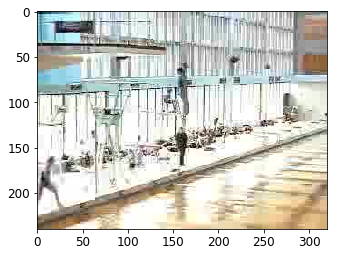

In [45]:
imagePath2 = '/home/adrian01/ucf101/train/Diving/v_Diving_g19_c04-0207.jpg'
image2 = cv2.imread(imagePath2)
print(plt.imshow(image2))

In [46]:
img2 = cv2.imread(imagePath2)
img2.shape

(240, 320, 3)

In [4]:
# (adapted from:
#   https://github.com/harvitronix/five-video-classification-methods/blob/master/processor.py 
#   https://github.com/fchollet/deep-learning-with-python-notebooks  )

# Process image and return array

def process_image(image, target_shape):
    # Load the image.
    h, w, _ = target_shape
    image = load_img(image, target_size=(h, w))

    # Turn it into numpy, normalize and return.
    img_arr = img_to_array(image)
    x = (img_arr / 255.).astype(np.float32)

    return x

In [5]:
# (adapted from:
#    https://github.com/harvitronix/five-video-classification-methods/blob/master/data.py )

class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

class DataSet():

    os.chdir('/home/adrian01/ucf101')
    
    def __init__(self, seq_length=80, class_limit=None, image_shape=(299, 299, 3)):
        """Constructor.
        seq_length = (int) the number of frames to consider
        class_limit = (int) number of classes to limit the data to.
            None = no limit.
        """
        self.seq_length = seq_length
        self.class_limit = class_limit
        self.sequence_path = os.path.join('/home/adrian01/ucf101', 'features02')
        self.min_frames = 2  # min number of frames a video can have for us to use it
        self.max_frames = 2000  # max number of frames a video can have for us to use it

        # Get the data.
        self.data = self.get_data()

        # Get the classes.
        self.classes = self.get_classes()

        # Minor data cleaning.
        self.data = self.clean_data()
        self.image_shape = image_shape

    @staticmethod
    def get_data():
        """Load our data from file."""
        with open(os.path.join('/home/adrian01/data_file.csv'), 'r') as fin:
            reader = csv.reader(fin)
            data = list(reader)

        return data

    def clean_data(self):
        """Limit samples to greater than the sequence length and fewer
        than N frames. Also limit it to classes we want to use."""
        data_clean = []
        for item in self.data:
            if int(item[3]) >= self.min_frames and int(item[3]) <= self.max_frames \
                    and item[1] in self.classes:
                data_clean.append(item)

        return data_clean

    def get_classes(self):
        """Extract the classes from our data. If we want to limit them,
        only return the classes we need."""
        classes = []
        for item in self.data:
            if item[1] not in classes:
                classes.append(item[1])

        # Sort them.
        classes = sorted(classes)

        # Return.
        if self.class_limit is not None:
            return classes[:self.class_limit]
        else:
            return classes

    def get_class_one_hot(self, class_str):
        """Given a class as a string, return its number in the classes
        list. This lets us encode and one-hot it for training."""
        # Encode it first.
        label_encoded = self.classes.index(class_str)

        # Then one-hot it.
        label_hot = to_categorical(label_encoded, len(self.classes))

        assert len(label_hot) == len(self.classes)

        return label_hot

    def split_train_test(self):
        """Split the data into train and test groups."""
        train = []
        test = []
        for item in self.data:
            if item[0] == 'train':
                train.append(item)
            else:
                test.append(item)
        return train, test

    def get_all_sequences_in_memory(self, train_test, data_type):
        """
        This is a mirror of our generator, but attempts to load everything into
        memory so we can train way faster.
        """
        # Get the right dataset.
        train, test = self.split_train_test()
        data = train if train_test == 'train' else test

        print("Loading %d samples into memory for %sing." % (len(data), train_test))

        X, y = [], []
        for row in data:

            if data_type == 'images':
                frames = self.get_frames_for_sample(row)
                frames = self.rescale_list(frames, self.seq_length)

                # Build the image sequence
                sequence = self.build_image_sequence(frames)

            else:
                sequence = self.get_extracted_sequence(data_type, row)

                if sequence is None:
                    print("Can't find sequence. Did you generate them?")
                    raise

            X.append(sequence)
            y.append(self.get_class_one_hot(row[1]))

        return np.array(X), np.array(y)

    @threadsafe_generator
    def frame_generator(self, batch_size, train_test, data_type):
        """Return a generator that we can use to train on. There are
        a couple different things we can return:
        data_type: 'features', 'images'
        """
        # Get the right dataset for the generator.
        train, test = self.split_train_test()
        data = train if train_test == 'train' else test

        print("Creating %s generator with %d samples." % (train_test, len(data)))

        while 1:
            X, y = [], []

            # Generate batch_size samples.
            for _ in range(batch_size):
                # Reset to be safe.
                sequence = None

                # Get a random sample.
                sample = random.choice(data)

                # Check to see if we've already saved this sequence.
                if data_type is "images":
                    # Get and resample frames.
                    frames = self.get_frames_for_sample(sample)
                    frames = self.rescale_list(frames, self.seq_length)

                    # Build the image sequence
                    sequence = self.build_image_sequence(frames)
                else:
                    # Get the sequence from disk.
                    sequence = self.get_extracted_sequence(data_type, sample)

                    if sequence is None:
                        raise ValueError("Can't find sequence. Did you generate them?")

                X.append(sequence)
                y.append(self.get_class_one_hot(sample[1]))

            yield np.array(X), np.array(y)

    def build_image_sequence(self, frames):
        """Given a set of frames (filenames), build our sequence."""
        return [process_image(x, self.image_shape) for x in frames]

    def get_extracted_sequence(self, data_type, sample):
        """Get the saved extracted features."""
        filename = sample[2]
        path = os.path.join(self.sequence_path, filename + '-' + str(self.seq_length) + \
            '-' + data_type + '.npy')
        if os.path.isfile(path):
            return np.load(path)
        else:
            return None

    def get_frames_by_filename(self, filename, data_type):
        """Given a filename for one of our samples, return the data
        the model needs to make predictions."""
        # First, find the sample row.
        sample = None
        for row in self.data:
            if row[2] == filename:
                sample = row
                break
        if sample is None:
            raise ValueError("Couldn't find sample: %s" % filename)

        if data_type == "images":
            # Get and resample frames.
            frames = self.get_frames_for_sample(sample)
            frames = self.rescale_list(frames, self.seq_length)
            # Build the image sequence
            sequence = self.build_image_sequence(frames)
        else:
            # Get the sequence from disk.
            sequence = self.get_extracted_sequence(data_type, sample)

            if sequence is None:
                raise ValueError("Can't find sequence. Did you generate them?")

        return sequence

    @staticmethod
    def get_frames_for_sample(sample):
        """Given a sample row from the data file, get all the corresponding frame
        filenames."""
        path = os.path.join('/home/adrian01/ucf101', sample[0], sample[1])
        filename = sample[2]
        images = sorted(glob.glob(os.path.join(path, filename + '*jpg')))
        return images

    @staticmethod
    def get_filename_from_image(filename):
        parts = filename.split(os.path.sep)
        return parts[-1].replace('.jpg', '')

    @staticmethod
    def rescale_list(input_list, size):

        if len(input_list) > size:
            skip = len(input_list) // size
            outpt = [input_list[i] for i in range(0, len(input_list), skip)]
            return outpt[:size]

        elif len(input_list) == size:
            outpt = [input_list[i] for i in range(0, len(input_list))]
            return outpt[:size]

        elif len(input_list) < size and len(input_list) > 2:
            add = 1 - (len(input_list) / size)
            a_c = 0
            x_c = 0
            outpt = []
            list_end = len(input_list) - 1
            for x in range(size):
                a_c += add
                x_c = np.ceil(x - a_c)
                x_c = x_c.astype(np.int16)
                if x_c <= list_end:
                    outpt.append(input_list[x_c])
                elif x_c > list_end:
                    outpt.append(input_list[list_end])
            return outpt[:size]

        else:
            outpt = []
            for x in range(size):
                outpt.append(input_list[0])
            return outpt[:size]
    
    def print_class_from_prediction(self, predictions, nb_to_return=5):
        """Given a prediction, print the top classes."""
        # Get the prediction for each label.
        label_predictions = {}
        for i, label in enumerate(self.classes):
            label_predictions[label] = predictions[i]

        # Now sort them.
        sorted_lps = sorted(
            label_predictions.items(),
            key=operator.itemgetter(1),
            reverse=True
        )

        # And return the top N.
        for i, class_prediction in enumerate(sorted_lps):
            if i > nb_to_return - 1 or class_prediction[1] == 0.0:
                break
            print("%s: %.2f" % (class_prediction[0], class_prediction[1]))

In [6]:
# (adapted from:
#    https://github.com/harvitronix/five-video-classification-methods/blob/master/models.py )

"""
A collection of models we'll use to attempt to classify videos.
"""

class ResearchModels():
    def __init__(self, nb_classes, model, seq_length,
                 saved_model=None, features_length=2048):
        """
        `model` = one of:
            lstm
            lstm_deep
            gru_deeper
            lrcn
            mlp
            conv_3d
            c3d
        `nb_classes` = the number of classes to predict
        `seq_length` = the length of our video sequences
        `saved_model` = the path to a saved Keras model to load
        """

        # Set defaults.
        self.seq_length = seq_length
        self.load_model = load_model
        self.saved_model = saved_model
        self.nb_classes = nb_classes
        self.feature_queue = deque()

        # Set the metrics. Only use top k if there's a need.
        metrics = ['accuracy']
        if self.nb_classes >= 10:
            metrics.append('top_k_categorical_accuracy')

        # Get the appropriate model.
        if self.saved_model is not None:
            print("Loading model %s" % self.saved_model)
            self.model = load_model(self.saved_model)
        elif model == 'lstm':
            print("Loading LSTM model.")
            self.input_shape = (seq_length, features_length)
            self.model = self.lstm()
        elif model == 'lstm_deep':
            print("Loading LSTM-DEEP model.")
            self.input_shape = (seq_length, features_length)
            self.model = self.lstm_deep()
        elif model == 'gru_deeper':
            print("Loading GRU-DEEPER model.")
            self.input_shape = (seq_length, features_length)
            self.model = self.gru_deeper()
        elif model == 'lrcn':
            print("Loading CNN-LSTM model.")
            self.input_shape = (seq_length, 80, 80, 3)
            self.model = self.lrcn()
        elif model == 'mlp':
            print("Loading simple MLP.")
            self.input_shape = (seq_length, features_length)
            self.model = self.mlp()
        elif model == 'conv_3d':
            print("Loading Conv3D")
            self.input_shape = (seq_length, 80, 80, 3)
            self.model = self.conv_3d()
        elif model == 'c3d':
            print("Loading C3D")
            self.input_shape = (seq_length, 80, 80, 3)
            self.model = self.c3d()
        else:
            print("Unknown network.")
            sys.exit()

        # Now compile the network.
        optimizer = Adam(lr=1e-5, decay=1e-6)
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                           metrics=metrics)

        print(self.model.summary())

    def lstm(self):
        """Build a simple LSTM network. We pass the extracted features from
        our CNN to this model predomenently."""
        # Model.
        model = Sequential()
        model.add(LSTM(2048, return_sequences=False,
                       input_shape=self.input_shape,
                       dropout=0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model

    def lstm_deep(self):
        """Build a deep LSTM network fed by InceptionV3-extracted features."""
        model = Sequential()
        model.add(LSTM(2048, return_sequences=True,
                       input_shape=self.input_shape,
                       dropout=0.1,
                       recurrent_dropout=0.5))
        model.add(LSTM(2048, return_sequences=False,
                       dropout=0.1,
                       recurrent_dropout=0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model
        
    def gru_deeper(self):
        """Build a deeper GRU network fed by InceptionV3-extracted features."""
        model = Sequential()
        model.add(GRU(2048, return_sequences=True,
                       input_shape=self.input_shape,
                       dropout=0.1,
                       recurrent_dropout=0.5))
        model.add(GRU(2048, return_sequences=True,
                       dropout=0.1,
                       recurrent_dropout=0.5))
        model.add(GRU(2048, return_sequences=False,
                       dropout=0.1,
                       recurrent_dropout=0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model
        
    def lrcn(self):
        """Build a CNN into RNN.
        Starting version from:
            https://github.com/udacity/self-driving-car/blob/master/
                steering-models/community-models/chauffeur/models.py
        Heavily influenced by VGG-16:
            https://arxiv.org/abs/1409.1556
        Also known as an LRCN:
            https://arxiv.org/pdf/1411.4389.pdf
        """
        model = Sequential()

        model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
            activation='relu', padding='same'), input_shape=self.input_shape))
        model.add(TimeDistributed(Conv2D(32, (3,3),
            kernel_initializer="he_normal", activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(64, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(128, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        
        model.add(TimeDistributed(Conv2D(512, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(0.5))
        model.add(LSTM(256, return_sequences=False, dropout=0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model

    def mlp(self):
        """Build a simple MLP. It uses extracted features as the input
        because of the otherwise too-high dimensionality."""
        # Model.
        model = Sequential()
        model.add(Flatten(input_shape=self.input_shape))
        model.add(Dense(512))
        model.add(Dropout(0.5))
        model.add(Dense(512))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model

    def conv_3d(self):
        """
        Build a 3D convolutional network, based loosely on C3D.
            https://arxiv.org/pdf/1412.0767.pdf
        """
        # Model.
        model = Sequential()
        model.add(Conv3D(
            32, (3,3,3), activation='relu', input_shape=self.input_shape
        ))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        model.add(Conv3D(64, (3,3,3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        model.add(Conv3D(128, (3,3,3), activation='relu'))
        model.add(Conv3D(128, (3,3,3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        model.add(Conv3D(256, (2,2,2), activation='relu'))
        model.add(Conv3D(256, (2,2,2), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Dropout(0.5))
        model.add(Dense(1024))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model

    def c3d(self):
        """
        Build a 3D convolutional network, aka C3D.
            https://arxiv.org/pdf/1412.0767.pdf
        With thanks:
            https://gist.github.com/albertomontesg/d8b21a179c1e6cca0480ebdf292c34d2
        """
        model = Sequential()
        # 1st layer group
        model.add(Conv3D(64, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv1',
                         subsample=(1, 1, 1),
                         input_shape=self.input_shape))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                               border_mode='valid', name='pool1'))
        # 2nd layer group
        model.add(Conv3D(128, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv2',
                         subsample=(1, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                               border_mode='valid', name='pool2'))
        # 3rd layer group
        model.add(Conv3D(256, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv3a',
                         subsample=(1, 1, 1)))
        model.add(Conv3D(256, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv3b',
                         subsample=(1, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                               border_mode='valid', name='pool3'))
        # 4th layer group
        model.add(Conv3D(512, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv4a',
                         subsample=(1, 1, 1)))
        model.add(Conv3D(512, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv4b',
                         subsample=(1, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                               border_mode='valid', name='pool4'))

        # 5th layer group
        model.add(Conv3D(512, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv5a',
                         subsample=(1, 1, 1)))
        model.add(Conv3D(512, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv5b',
                         subsample=(1, 1, 1)))
        model.add(ZeroPadding3D(padding=(0, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                               border_mode='valid', name='pool5'))
        model.add(Flatten())

        # FC layers group
        model.add(Dense(4096, activation='relu', name='fc6'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu', name='fc7'))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))
        
        return model

In [ ]:
# (adapted from:
#     https://github.com/harvitronix/five-video-classification-methods/blob/master/train.py#L18 )

def train(data_type, seq_length, model, saved_model=None,
          class_limit=None, image_shape=None,
          load_to_memory=False, batch_size=8, nb_epoch=1000):
    # Helper: Save the model.
    checkpointer = ModelCheckpoint(
        filepath=os.path.join('/home/adrian01/ucf101', 'checkpoints', model + '-' + data_type + \
            '.{epoch:03d}-{val_loss:.3f}.hdf5'),
        verbose=1,
        save_best_only=True)

    # Helper: TensorBoard
    tb = TensorBoard(log_dir=os.path.join('/home/adrian01/ucf101', 'logs', model))

    # Helper: Stop when we stop learning.
    early_stopper = EarlyStopping(patience=5)

    # Helper: Save results.
    timestamp = time.time()
    csv_logger = CSVLogger(os.path.join('/home/adrian01/ucf101', 'logs', model + '-' + \
                                        'training-' + str(timestamp) + '.log'))

    # Get the data and process it.
    if image_shape is None:
        data = DataSet(
            seq_length=seq_length,
            class_limit=class_limit
        )
    else:
        data = DataSet(
            seq_length=seq_length,
            class_limit=class_limit,
            image_shape=image_shape
        )

    # Get samples per epoch.
    # Multiply by 0.7 to attempt to guess how much of data.data is the train set.
    steps_per_epoch = (len(data.data) * 0.7) // batch_size

    if load_to_memory:
        # Get data.
        X, y = data.get_all_sequences_in_memory('train', data_type)
        X_test, y_test = data.get_all_sequences_in_memory('test', data_type)
    else:
        # Get generators.
        generator = data.frame_generator(batch_size, 'train', data_type)
        val_generator = data.frame_generator(batch_size, 'test', data_type)

    # Get the model.
    rm = ResearchModels(len(data.classes), model, seq_length, saved_model)

    # Fit!
    if load_to_memory:
        # Use standard fit.
        rm.model.fit(
            X,
            y,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            verbose=1,
            callbacks=[tb, early_stopper, csv_logger],
            epochs=nb_epoch)
    else:
        # Use fit generator.
        rm.model.fit_generator(
            generator=generator,
            steps_per_epoch=steps_per_epoch,
            epochs=nb_epoch,
            verbose=1,
            callbacks=[tb, early_stopper, csv_logger, checkpointer],
            validation_data=val_generator,
            validation_steps=40,
            workers=4)

def main():
    """These are the main training settings. Set each before running
    this file."""
    # model can be one of lstm, lrcn, mlp, conv_3d, c3d
    model = 'gru_deeper'
    saved_model = None  # None or weights file
    class_limit = None  # int, can be 1-101 or None
    seq_length = 80
    load_to_memory = False  # pre-load the sequences into memory
    batch_size = 8
    nb_epoch = 1000

    # Chose images or features and image shape based on network.
    if model in ['conv_3d', 'c3d', 'lrcn']:
        data_type = 'images'
        image_shape = (80, 80, 3)
    elif model in ['lstm', 'lstm_deep', 'gru_deeper', 'mlp']:
        data_type = 'features'
        image_shape = None
    else:
        raise ValueError("Invalid model. See train.py for options.")

    train(data_type, seq_length, model, saved_model=saved_model,
          class_limit=class_limit, image_shape=image_shape,
          load_to_memory=load_to_memory, batch_size=batch_size, nb_epoch=nb_epoch)

if __name__ == '__main__':
    main()

In [8]:
# Clear before running next model:
#K.clear_session()